### 아이리스 품종 분류 예측 (2진분류)
- 데이터셋: iris.csv
- 피쳐: 4개
- 타겟: 1개 (Setosa & the rest)
- 학습방법: 지도학습 >> 분류 >> 2진 분류
- 알고리즘: DNN (심층신경망)
- 프레임워크: pytorch

In [64]:
# 모듈 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# DF 로드 및 시각화 모듈
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리용 모듈
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [65]:
# 모듈 버전 확인
def ver_check():
    print(f'torch v.{torch.__version__}')
    print(f'pandas v.{pd.__version__}')

In [66]:
ver_check()

torch v.2.4.1
pandas v.2.0.3


In [67]:
DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE)
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


#### variety 인코딩
- Setosa -> 1 & 나머지 -> 0

In [68]:
label = dict(zip(irisDF['variety'].unique().tolist(), [1,0,0]))
print(label)

{'Setosa': 1, 'Versicolor': 0, 'Virginica': 0}


In [69]:
irisDF['variety_encd'] = irisDF['variety'].replace(label)
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety,variety_encd
0,5.1,3.5,1.4,0.2,Setosa,1
1,4.9,3.0,1.4,0.2,Setosa,1
2,4.7,3.2,1.3,0.2,Setosa,1


In [70]:
# 타겟&피쳐 && train&valid&test 분리
targetDF = irisDF[['variety_encd']]
# featureDF = irisDF.drop('petal.width', axis=1)
featureDF = irisDF[irisDF.columns[:-2]]

print(f'featureDF: {featureDF.shape} {featureDF.ndim}D')
print(f'targetDF: {targetDF.shape} {targetDF.ndim}D')

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)

print()
print(f'X_trian: {X_train.shape} {X_train.ndim}D')
print(f'y_trian: {y_train.shape} {y_train.ndim}D')
print(f'X_val: {X_val.shape} {X_val.ndim}D')
print(f'y_val: {y_val.shape} {y_val.ndim}D')
print(f'X_test: {X_test.shape} {X_test.ndim}D')
print(f'y_test: {y_test.shape} {y_test.ndim}D')

featureDF: (150, 4) 2D
targetDF: (150, 1) 2D

X_trian: (84, 4) 2D
y_trian: (84, 1) 2D
X_val: (28, 4) 2D
y_val: (28, 1) 2D
X_test: (38, 4) 2D
y_test: (38, 1) 2D


#### 분류 모델 클래스 생성 && 최적화 & 활성화 & 손실 함수 정의
- 클래스이름: IrisBiCFModel
- 클래스목적: 품종 분류 (Setosa & the rest)
- 부모클래스: nn.Module
- 매개_변수: layer별 입출력 고정 -> 불필요
- 기능/역할: init(), forward()
- 클래스 구조:
	* 입력층:	입력 4		출력 10		AF ReLU
	* 은닉층:	입력 10		출력 20		AF ReLU
	* 은닉층:	입력 20		출력 5 		AF ReLU
	* 출력층:	입력 5		출력 1		AF sigmoid
- 손실함수/활성화함수
	* 손실함수		-> BinaryCrossEntropyLoss
	* 활성화함수	-> Relu, leakReLU

In [71]:
class IrisBiCFModel(nn.Module):
    
	def __init__(self):
		super().__init__()

		self.in_layer  = nn.Linear(4, 10)
		self.hd_layers = nn.ModuleList([ nn.Linear(10,20), nn.Linear(20, 5)])
		self.out_layer = nn.Linear(5, 1)
									# 분류기 1개

	def forward(self, x):

		y = F.leaky_relu( self.in_layer(x) )

		for linear in self.hd_layers:
			y = F.leaky_relu( linear(y) )

		return F.sigmoid( self.out_layer(y) )
	
	

In [72]:
# [테스트] 사용자 정의 모델 인스턴스 체크
model = IrisBiCFModel()

print(model)
print()
summary(model, input_size=(150, 4))

IrisBiCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=5, bias=True)
  )
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)



Layer (type:depth-idx)                   Output Shape              Param #
IrisBiCFModel                            [150, 1]                  --
├─Linear: 1-1                            [150, 10]                 50
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-1                       [150, 20]                 220
│    └─Linear: 2-2                       [150, 5]                  105
├─Linear: 1-3                            [150, 1]                  6
Total params: 381
Trainable params: 381
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

#### 데이터셋 클래스 생성
- 데이터셋: iris.csv
- 피쳐개수: 4개
- 타겟개수: 2개
- 클래스이름: IrisDataset
- 부모클래스: Dataset
- 속성/필드: featureDF, targetDF, n_rows, n_features
- 필수 메서드:
	* init(self) : 데이터 저장 및 전처리, 개발자가 필요한 속성 설정
	* len(self)	 : 데이터 개수 반환
	* getitem(self,idx): 특정인덱스 피쳐/타겟 반환

In [73]:
class IrisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):
		self.featreDF = featureDF
		self.targetDF = targetDF

		self.n_rows = featureDF.shape[0]
		self.n_features = featureDF.shape[1]

	def __len__(self):
		return self.n_rows

	def __getitem__(self, idx):

		featureTS = torch.FloatTensor(featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor(targetDF.iloc[idx].values)

		return featureTS, targetTS

In [74]:
# [테스트] 사용자 정의 데이터셋 클래스 확인
trainDS = IrisDataset(X_train, y_train)

for feature, label in trainDS:
    print(feature, label)
    break

del trainDS

tensor([5.1000, 3.5000, 1.4000, 0.2000]) tensor([1.])


#### 학습 준비
* EPOCH, BATCH_SIZE, BATCH_CNT, DEVICE,
* LR
* 성능지표함수
* 손실함수
* 최적화함수

In [75]:
# 모델 하이퍼 파라미터 설정
EPOCH = 100
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

# 최적화 함수
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수
clfLoss = nn.BCELoss()

# 성능지표 함수
scoreFunc = BinaryF1Score()

In [76]:
# trainDS, validDS, testDS
trainDS = IrisDataset(X_train, y_train)
validDS = IrisDataset(X_val, y_val)
testDS  = IrisDataset(X_test, y_test)

# train 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE)

#### 학습 진행

In [77]:
LOSS_history = {'Train':[], 'Val':[] }
SCORE_history = {'Train':[], 'Val':[] }

BATCH_CNT = len(trainDL)

for ep in range(EPOCH):

	# 모델 학습 모드 전환
	model.train()

	loss_total = 0
	score_total = 0

	for featureTS, targetTS in trainDL:

		pre_y = model(featureTS)

		loss = clfLoss(pre_y, targetTS)
		loss_total += loss.item()

		score = scoreFunc(pre_y, targetTS).item()
		score_total += score

		# 최적화 
		optimizer.zero_grad()                              
		loss.backward()
		optimizer.step()

	# 모델 검증 모드 변환
	model.eval()

	with torch.no_grad():

		val_featTS = torch.FloatTensor(validDS.featreDF.values)
		val_targTS = torch.FloatTensor(validDS.targetDF.values)
		
		pre_val = model(val_featTS)
		loss_val = clfLoss(pre_val, val_targTS).item()
		score_val = scoreFunc(pre_val, val_targTS).item()
    
	# 한 에포크 당 손실값&성능지표값 저장
	LOSS_history['Train'].append(loss_total/BATCH_CNT)
	SCORE_history['Train'].append(score_total/BATCH_CNT)

	LOSS_history['Val'].append(loss_val)
	SCORE_history['Val'].append(score_val)

	if ep%20 ==0: 
		print(f"[{ep}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} Score: {SCORE_history['Train'][-1]:.5f}")
		print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} Score: {SCORE_history['Val'][-1]:.5f}")
		


[0/100]
- [Train] LOSS: 0.69743 Score: 0.00000
- [Valid] LOSS: 0.68336 Score: 0.15385


[20/100]
- [Train] LOSS: 0.32774 Score: 0.55556
- [Valid] LOSS: 0.25331 Score: 1.00000
[40/100]
- [Train] LOSS: 0.03611 Score: 0.55556
- [Valid] LOSS: 0.02250 Score: 1.00000
[60/100]
- [Train] LOSS: 0.00926 Score: 0.55556
- [Valid] LOSS: 0.00559 Score: 1.00000
[80/100]
- [Train] LOSS: 0.00410 Score: 0.55556
- [Valid] LOSS: 0.00244 Score: 1.00000


#### 학습 결과 시각화
* 학습 & 검증의 Loss 변화
* 학습 & 검증의 score 변화

Text(0.5, 1.0, 'f1-score')

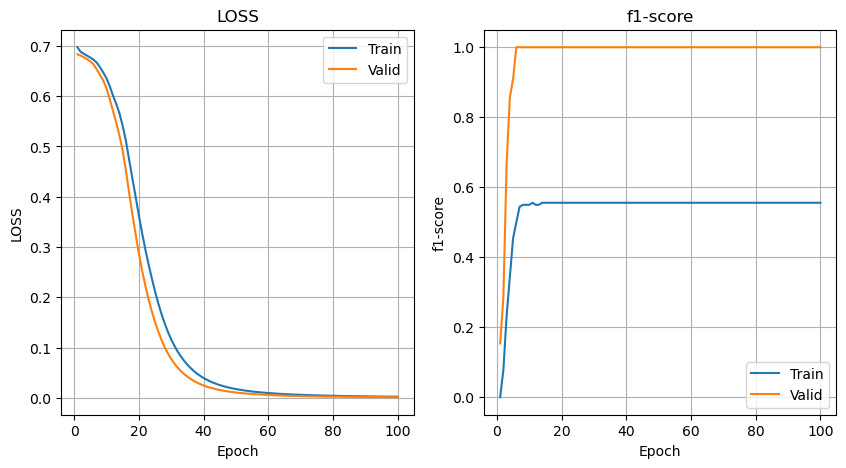

In [78]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(range(1, EPOCH+1), LOSS_history['Train'],label="Train")
axes[0].plot(range(1, EPOCH+1), LOSS_history['Val'],label="Valid")
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("LOSS")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_history['Train'],label="Train")
axes[1].plot(range(1, EPOCH+1), SCORE_history['Val'],label="Valid")
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("f1-score")
axes[1].set_title("f1-score")

In [79]:
## Test DS 확인
test_featTS = torch.FloatTensor(testDS.featreDF.values)
test_targTS = torch.FloatTensor(testDS.targetDF.values)

pre_test = model(test_featTS)

print(f'[TEST]\nLOSS: {clfLoss(pre_test, test_targTS):.5f} SCORE:{scoreFunc(pre_test, test_targTS):.5f}')

[TEST]
LOSS: 0.00231 SCORE:1.00000


In [80]:
model(test_featTS[8])

tensor([0.9975], grad_fn=<SigmoidBackward0>)